# Quantitative Investment Analysis (Hedge Fund)

## Data Description
There are a total of 11 csv files and the main file of interest is returns.csv. This file contains daily returns data of 200 assets from August 1, 2017 to July 16, 2018. Daily returns are typically represented as percent change in the return of an asset from the current day to the previous day. The other 10 csv files are labeled signal01, signal02, ..., signal10. These files have a similar structure to the returns.csv data. In each signal file, there are values for all 200 assets from August 1, 2017 to July 16, 2018. The signal files may help predict the asset returns and the assumption is that each asset has only 10 signal variables as possible predictors for the returns.  

## Question 1
#### The returns.csv file contains daily returns for 200 assets over roughly one year. A random subset of the data has been selected and deleted, so that approximately 2% of the data is missing. Impute the missing values.  

For question 1, I took the following steps. First, I imported the main libraries and read in the returns.csv file while parsing date column as an index. Before examining the data, I found the total percentage of missing data and used a 5 day rolling mean across columns to impute the missing values. However, columns that have the first value missing were not filled so I just imputed the remaining missing values with the column mean. 

To better understand the returns data, I plotted a couple of random assets and performed the Augmented Dickey-Fuller test to test if each time series is stationary. Performing this test 200 times for each asset introduces type I error but almost every p-value was virtually zero and the largest p-value was 0.043. I felt comfortableto to reject the null hypothesis on every test and conclude that the returns data are stationary and white noise. 

In [1]:
# Import main libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# Change working directory to the folder with returns.csv, signal01.csv, ..., signal10.csv
os.chdir('E:/TakeHome')

# Read in returns.csv and parse dates 
returns = pd.read_csv('returns.csv', parse_dates = ['date'], index_col = 'date')

In [3]:
# Find total percentage of missing data in returns.csv

print(str((returns.isnull().sum(axis = 0).sum()) / (returns.shape[0] * returns.shape[1]) * 100) + 
      ' % of all returns data is missing, must impute those with some metric')

1.91 % of all returns data is missing, must impute those with some metric


In [4]:
# Print out the column name with the most missing values and its count

print('The largest number of missing values for an asset is ' + str(returns.isnull().sum().max()))
print('The asset with the largest number of missing values is ' + str(returns.isnull().sum().idxmax()))

The largest number of missing values for an asset is 13
The asset with the largest number of missing values is asset_142


In [5]:
# Replace missing values in returns.csv with the column's 5 day rolling mean

returns_rolling_5 = returns.rolling(window = '5D').mean()

count = 0
for i in range(0,returns.shape[0]):
    for j in range(0, returns.shape[1]):
        if pd.isnull(returns.iloc[i,j]):
            returns.iat[i,j] = returns_rolling_5.iat[i,j]

In [6]:
# Check if any missing values still exist. The small percentage of missing values still remaining are if columns 
# the first observation missing. Use column means to fill in the last few missing data. 

print(str((returns.isnull().sum(axis = 0).sum()) / (returns.shape[0] * returns.shape[1]) * 100) + 
      ' % still missing, impute those with mean of column')

0.01 % still missing, impute those with mean of column


In [7]:
# Fill in the rest of missing data with column means and check if any missing data still exists

returns = returns.fillna(returns.mean(axis = 0))
print('Number of missing values remaining is ' + str(returns.isnull().sum().sum()))

Number of missing values remaining is 0


In [8]:
# Test for statinary series for all 200 asset returns. All tests reject null hypothesis that series is not stationary.
# Therefore, there is significant evidence to suggest that all returns are stationary, white noise. 

from statsmodels.tsa.stattools import adfuller

pvals = []
for i in returns.columns:
    answer = adfuller(returns[i])
    pvals.append(answer[1])
    
pvals = np.array(pvals)
print('The largest p-value from the Augmented Dickey-Fuller test is ' + str(pvals.max()))
print('The asset number with the largest Augmented Dickey-Fuller p-value is '  + str(pvals.argmax()))

C:\Users\Ruslan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The largest p-value from the Augmented Dickey-Fuller test is 0.0434767611358
The asset number with the largest Augmented Dickey-Fuller p-value is 119


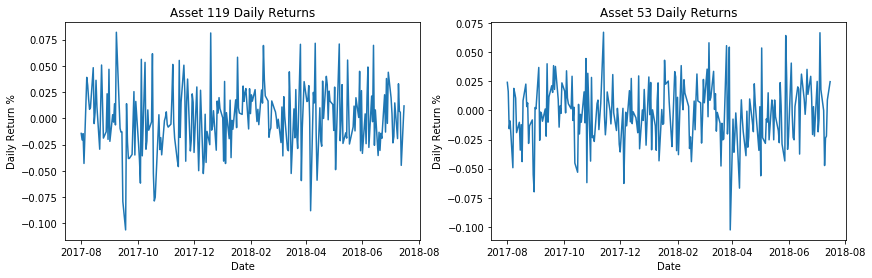

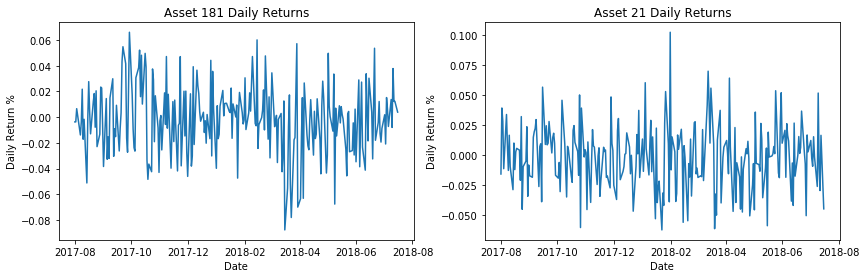

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(returns['asset_119'])
plt.title('Asset 119 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return %')

plt.subplot(1,2,2)
plt.plot(returns['asset_053'])
plt.title('Asset 53 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return %')
plt.show()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(returns['asset_181'])
plt.title('Asset 181 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return %')

plt.subplot(1,2,2)
plt.plot(returns['asset_021'])
plt.title('Asset 21 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return %')
plt.show()

## Question 2
#### Still based on the returns.csv file, what is the expected volatility (i.e. the expected annualized standard deviation of the return) of a uniform, fully invested, portfolio (a portfolio which holds 1/200 unit of account in each asset)? Furthermore, find the fully invested minimum volatility portfolio (i.e. the long short portfolio which has the minimum expected volatility and whose holdings sum to 1).

In question 2 part 1, I need to compute the expected annual volatility (measured in % standard deviations) of a full invested portfolio of 200 assets, each with equal weight. First, I initialized an array of 200 weights, each with a value of (1/200). There is a constraint that the weights must sum to 1. I researched the formula for expected annual volatility of more than 2 assets and the url of the websites used are listed below. 

To find the expected annual standard deviation, I needed to compute the covariance matrix of the returns and annualize it by multiplying by the square root of 252 (number of business days in 1 year). I used annual covariance matrix (cov) and weights (w) in the formula, square root(w.T * (cov) * w) * square root(252). Also, I computed the annual mean returns by finding the daily returns and annualizing it as well.

In question 2 part 2, I researched the Markowitz Portfolio Theory or Modern Portfolio Theory which explains for a given level of risk, to maximize the expected returns by optimizing the weights given to each asset. If all weights are uniform and equal, than the expected annual return is -0.273% and the expected annual standard deviation of the return is 6.382%. Ideally, we would like to find some combination of weights of the 200 assets that increase the expected annual return while decreasing the expected annual volatility. I simulated a new set of weights to calculate the expected annual return, expected annual standard deviation, and the sharpe ratio which is a ratio of the expected annual return to the expected annual volatility. I simulated 200,000 different portfolios where each portfolio has all 200 assets with random weights assigned. I normalized the weights to sum to 1 to comply with the sum to 1 constraint. A plot of the expected annual return vs expected standard deviation of the 200,000 simulations can determine for a given level of risk, the maximum expected returns. The weights corresponding to any of the 200,000 portfolio simulations are stored and can easily be retrieved.   


https://www.aaii.com/computerized-investing/article/mean-variance-optimization-multi-asset-portfolio.touch
http://programmingforfinance.com/2017/10/generating-a-minimum-variance-portfolio-and-the-efficient-frontier/

https://financetrain.com/the-minimum-variance-frontier-efficient-frontier/
https://medium.com/python-data/effient-frontier-in-python-34b0c3043314

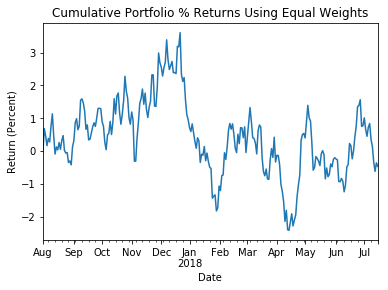

Overall expected annualized mean of returns is -0.273%
Overall expected annualized standard deviation of returns is 6.382%


In [31]:
# Create a vector of 200 weights, each being (1/200) and create a annualized covariance matrix of the assets. 

weights = np.array([1/200] * 200)
cov = returns.cov() * 252

# Use the dot product of daily returns of each asset for a given day and weights to find the average daily return. 
# Find the annualized portfolio return using the formula ((1 + avgerage_daily_return)^252) - 1 for decimal. Multiply by 100 
# for percentage. 

avg_daily_return = returns.mul(weights, axis = 1).sum(axis = 1).mean()

cumulative_returns = ((1 + returns.mul(weights, axis = 1).sum(axis = 1)).cumprod() - 1) * 100
cumulative_returns.plot()
plt.title('Cumulative Portfolio % Returns Using Equal Weights')
plt.xlabel('Date')
plt.ylabel('Return (Percent)')
plt.show()

annualized_portfolio_return = ((1 + avg_daily_return)**252) - 1
print('Overall expected annualized mean of returns is ' + 
      str(np.round(annualized_portfolio_return * 100, 3)) + '%')

# square root of W^(t) * sigma * W and then multiply by sq.root of 252 for annualizing expected standard deviation of all returns
annualized_portfolio_std = np.sqrt(np.dot(weights.T,np.dot(cov, weights))) 
print('Overall expected annualized standard deviation of returns is ' + 
      str(np.round(annualized_portfolio_std * 100, 3)) + '%')

In [11]:
# Simulate many different weights 
np.random.seed(2)

# Initialize empty arrays to store results and compute the annual covariance matrix
annualized_portfolio_returns = np.array([])
annualized_portfolio_std = np.array([])
sharpe = np.array([])
weights = np.zeros(shape = (200000,200))
cov_annual = returns.cov() * 252

# Simulate 200,000 portfolios with random 200 weights and compute the annualized portfolio returns and standard deviations
i = 0
while i < 200000:
    #if i % 10000 == 0:
        #print(i)
    w = np.random.random(200)
    w = np.array(w / np.sum(w))
    weights[i] = w
    annualized_portfolio_returns = np.append(annualized_portfolio_returns, ((1 + returns.mul(w, axis = 1).sum(axis = 1).mean())**252) - 1)
    annualized_portfolio_std = np.append(annualized_portfolio_std, np.sqrt(np.dot(w.T,np.dot(cov_annual, w))))
    i = i + 1
sharpe = np.append(sharpe, annualized_portfolio_returns / annualized_portfolio_std)

The scatter plot below plots the simulated expected annual returns and standard deviations. The black dot displays the expected annual mean returns and expected annual volatility of the returns if the fully invested portfolio has equal, uniform weight to each asset. Anything to the left and above the black dot represents a better portfolio with higher return and less volatility determined by the weights attached to each asset.  

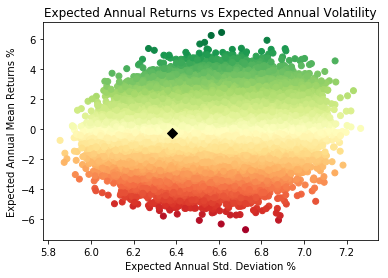

In [12]:
plt.scatter(annualized_portfolio_std * 100, annualized_portfolio_returns * 100, c = sharpe, cmap='RdYlGn')
plt.xlabel('Expected Annual Std. Deviation %')
plt.ylabel('Expected Annual Mean Returns %')
plt.title('Expected Annual Returns vs Expected Annual Volatility')
plt.scatter(x = 0.06382 * 100, y = -0.00273 * 100, c = 'black', marker = 'D', s = 50)
plt.show()

The minimum volatility in percent standard deviations is 5.855
The maximum sharpe ratio is 0.977


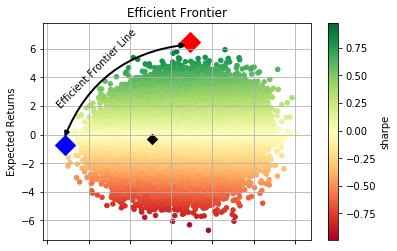

The portfolio with the minimum volatility is printed below
             ret    sharpe      std
189035 -0.734553 -0.125447  5.85549

The portfolio with the maximum sharpe is printed below
             ret    sharpe       std
134714  6.460197  0.976858  6.613237



In [13]:
results = {'ret': annualized_portfolio_returns * 100, 'std': annualized_portfolio_std * 100, 'sharpe': sharpe}
results = pd.DataFrame(results)

min_volatility = results['std'].min()
print('The minimum volatility in percent standard deviations is ' + str(np.round(min_volatility,3)))
max_sharpe = results['sharpe'].max()
print('The maximum sharpe ratio is ' + str(np.round(max_sharpe,3)))

sharpe_portfolio = results.loc[results['sharpe'] == max_sharpe]
min_variance_port = results.loc[results['std'] == min_volatility]

results.plot.scatter(x='std', y='ret', c='sharpe', cmap='RdYlGn', grid=True)
plt.scatter(x=sharpe_portfolio['std'], y=sharpe_portfolio['ret'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['std'], y=min_variance_port['ret'], c='blue', marker='D', s=200)
plt.scatter(x = 0.06382 * 100, y = -0.00273 * 100, c = 'black', marker = 'D', s = 50)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.annotate('', xy=(0.066 * 100, 0.063 * 100),  xytext=(0.0585 * 100,-0.003 * 100), arrowprops=dict(arrowstyle="<|-|>", 
                                                                connectionstyle="arc3,rad=-0.3", lw = 2))
plt.text(x = 0.058 * 100, y = 0.07 * 100, s = 'Efficient Frontier Line', rotation = 45)
plt.show()

#print(sharpe_portfolio)
print('The portfolio with the minimum volatility is printed below')
print(min_variance_port)
print('')
print('The portfolio with the maximum sharpe is printed below')
print(sharpe_portfolio)
print('')

#print('The weights of the portfolio with the minimum volatility are printed below')
#print(weights[min_variance_port.index])
#results.iloc[results['sharpe'].idxmax()]
#weights[results['sharpe'].idxmax()]

The scatter plot above is similar to the plot before but has additional labels. The red square represents the portfolio with the largest sharpe ratio (expected returns to expected volatility). The blue square represents the portfolio with the smallest expected annual volatility. The arrow connecting the blue and red dot represents the 'efficient frontier' or the maximum expected annual return for a given level of risk. The black dot is also shown representing the expected returns and expected volatility if weights to each asset are uniform (1/200). 

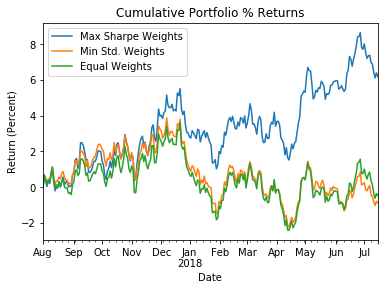

In [14]:
w1 = weights[results['sharpe'].idxmax()]
w2 = weights[results['std'].idxmin()]
w3 = np.repeat(1/200, 200)

cumulative_returns_1 = ((1 + returns.mul(w1, axis = 1).sum(axis = 1)).cumprod() - 1) * 100
cumulative_returns_2 = ((1 + returns.mul(w2, axis = 1).sum(axis = 1)).cumprod() - 1) * 100
cumulative_returns_3 = ((1 + returns.mul(w3, axis = 1).sum(axis = 1)).cumprod() - 1) * 100
cumulative_returns_1.plot()
cumulative_returns_2.plot()
cumulative_returns_3.plot()
plt.title('Cumulative Portfolio % Returns')
plt.xlabel('Date')
plt.ylabel('Return (Percent)')
plt.legend(['Max Sharpe Weights','Min Std. Weights','Equal Weights'])
plt.show()

## Question 3
#### An analyst has sent you ten signal candidates (in the files signal01.csv to signal10.csv) to help predict the returns of the 200 assets. Predict the returns of these 200 assets on July 17, 2018.

In question 3, the signal files are now introduced. I would like to find some model that could best predict the 200 asset returns for the future date (July 17, 2018). The asset variables in the signal files can be used as explanatory variables to predict the response variable (daily percentage returns). However, to predict the July 17, 2018 returns, we must have signal data for that day to use in the model but the last data points fall on July 16th, 2018. Therefore, lags must be created for the signal variables so that there can be values for July 17, 2018. For example, a lag 1 would mean that the values are shifted up 1 time period so that the July 16, 2018 value is now on July 17, 2018. In other words, today's value is replaced with yesterday's value. 

In the following steps I read in the 10 signal files and stored each file as a dictionary with the dataframe as the values. I merged the dictionary into one big dataframe, edited the column names, and re-ordered the columns in the order of assets 1, 2, 3,...,200. I created the first 3 lags for each signal variable as well as the first 3 lags of the returns. However, due to possible degress of freedom issue and too many paramter estimates for all 3 lags given only 1 year of data, I decided to limit the modeling to only 2 lags. Next, I created a dictionary with 200 keys for each asset. Within each key, is the X dataframe or dataframe with all explanatory variables (23) made up of lag1 and lag2 of the signal variables. I also included the lags for the 200 return assets as well.     

In [15]:
# Read in all 10 signal.csv files and store each signal file in a dictionary. The keys of the dictionary are the 
# signal file names (signal01, signal02, ..., signal10) and the values are the dataframe that corresponds to the signal file

files = []
x = 'signal01'
for i in range(1, 10):
    files.append(x.replace('signal01', "signal0{0}".format(i)))
files.append('signal10')
files = np.array(files)

signal_dict = {}
for i in range(1, len(sorted(os.listdir()))):
    signal_dict[files[i-1]] = pd.read_csv(sorted(os.listdir())[i], parse_dates = ['date'], index_col = 'date')

In [16]:
# Merge or concatenate the signal files dictionary into one big dataframe and create a list of column names to use

merged = pd.concat(signal_dict, axis = 1)
columns = []
for i, col in enumerate(merged, 1):
   columns.append('_'.join(col)) 

In [17]:
# Drop multilevel index created by pd.concat and replace column names with the names created in previous cell

merged.columns = merged.columns.droplevel(0)
merged.columns = columns
#merged.head()

In [18]:
# In the merged dataframe, the 10 assets belonging to each signal are not ordered together. Therefore, I created 
# the merged_sorted dataframe that fixes the ordering issue.

merged_sorted = merged
merged_sorted = pd.DataFrame()
nums = [x for x in range(0,200)]
for i in nums:
    for j in range(i, 2000, 200):
        merged_sorted = pd.DataFrame(merged.iloc[:,j]).join(merged_sorted)
merged_sorted = merged_sorted[merged_sorted.columns[::-1]]
merged_sorted.head()

,signal01_asset_001,signal02_asset_001,signal03_asset_001,signal04_asset_001,signal05_asset_001,signal06_asset_001,signal07_asset_001,signal08_asset_001,signal09_asset_001,signal10_asset_001,...,signal01_asset_200,signal02_asset_200,signal03_asset_200,signal04_asset_200,signal05_asset_200,signal06_asset_200,signal07_asset_200,signal08_asset_200,signal09_asset_200,signal10_asset_200
date,,,,,,,,,,,,,,,,,,,,,
2017-08-01,-1.168387,1.159986,-0.223249,-1.164630,0.484359,0.739784,0.115292,0.594901,0.717800,-1.288582,...,-0.125124,-0.326864,-0.805848,0.396315,-0.967113,-0.502364,-0.049274,-1.053405,-0.596218,-1.801552
2017-08-02,-0.413213,0.810865,-0.010538,-1.013336,0.373280,1.313114,0.790426,0.853965,0.451625,-2.038280,...,0.211611,-0.180577,-0.735702,-0.097691,-1.851221,-0.139176,-0.355266,-0.930712,-0.687561,-1.740581
2017-08-03,-0.451158,0.387060,0.510103,-0.222454,0.041235,1.264830,0.817706,1.263056,0.894613,-1.926692,...,0.653711,-0.460515,-1.020880,0.393608,-1.696081,-0.708548,-0.822174,-0.722398,-1.067500,-1.731678
2017-08-04,-0.237304,1.079991,1.251739,-0.907847,-0.416804,0.669189,0.393538,1.734165,1.147290,-1.846458,...,0.756019,-0.588296,-0.771733,-0.224353,-1.587377,0.198416,0.510926,-0.863889,-0.781499,-2.371663
2017-08-07,1.051456,1.137999,0.479205,-1.174816,-0.376281,0.021211,0.037895,1.955180,1.578434,-1.758962,...,0.627430,-0.178906,-0.405392,-1.223429,-1.989060,0.265048,0.323598,-0.854758,-0.598891,-2.412799


In [19]:
# lags for signal variables

signals_lag1 = merged_sorted.shift(periods = 1)
signals_lag1 = signals_lag1.append(merged_sorted.iloc[-1,:])
signals_lag1.index = pd.date_range(start = '2017-08-01', end = '2018-07-17', freq = 'B')
signals_lag1.columns = ['lag1_' + names for names in signals_lag1.columns]

signals_lag2 = merged_sorted.shift(periods = 2)
signals_lag2 = signals_lag2.append(merged_sorted.iloc[[-2,-1],:])
signals_lag2.index = pd.date_range(start = '2017-08-01', end = '2018-07-18', freq = 'B')
signals_lag2.columns = ['lag2_' + names for names in signals_lag2.columns]

signals_lag3 = merged_sorted.shift(periods = 3)
signals_lag3 = signals_lag3.append(merged_sorted.iloc[[-3,-2,-1],:])
signals_lag3.index = pd.date_range(start = '2017-08-01', end = '2018-07-19', freq = 'B')
signals_lag3.columns = ['lag3_' + names for names in signals_lag3.columns]

In [20]:
# lags for stock returns

returns_lag1 = returns.shift(periods = 1)
returns_lag1 = returns_lag1.append(returns.iloc[-1,:])
returns_lag1.index = pd.date_range(start = '2017-08-01', end = '2018-07-17', freq = 'B')
returns_lag1.columns = ['returns_lag1_' + names for names in returns_lag1.columns]

returns_lag2 = returns.shift(periods = 2)
returns_lag2 = returns_lag2.append(returns.iloc[[-2,-1],:])
returns_lag2.index = pd.date_range(start = '2017-08-01', end = '2018-07-18', freq = 'B')
returns_lag2.columns = ['returns_lag2_' + names for names in returns_lag2.columns]

returns_lag3 = returns.shift(periods = 3)  
returns_lag3 = returns_lag3.append(returns.iloc[[-3,-2,-1],:])
returns_lag3.index = pd.date_range(start = '2017-08-01', end = '2018-07-19', freq = 'B')
returns_lag3.columns = ['returns_lag3_' + names for names in returns_lag3.columns]

In [21]:
# Create a dictionary for the largest lag that maps assets to its signal variables. The largest lag is 3 but for with only about
# 250 data values for each asset, I limited the number of lags to use in modeling to just 2. 

nums = [x for x in range(0,2000,10)]
lag2_with_returns = {}
j = 0

for i in nums:
    lag2_with_returns[returns.columns[j]] = signals_lag2.iloc[:,range(i,i+10,1)]
    j += 1

In [22]:
# Due to degrees of freedom issues and only about 250 data points, I limited the lags to use to just 2. 
# If you want to use all 3 lags, remove the commented code.

X_with_Lags_dict = {}
nums = [x for x in range(0,2000,10)]
for i, val in enumerate(nums,0):
    #X_dict[returns.columns[i]] = lag3_with_returns[returns.columns[i]].join(signals_lag2.iloc[:,range(val,val + 10)])
    
    # If using 3 lags, call the dictionary X_with_lags_dict to use instead of lag2_with_returns on the line below
    X_with_Lags_dict[returns.columns[i]] = lag2_with_returns[returns.columns[i]].join(signals_lag1.iloc[:,range(val,val + 10)])
    
    #X_with_Lags_dict[returns.columns[i]] = X_with_Lags_dict[returns.columns[i]].join(signals_lag1.iloc[:,range(val,val + 10)])
    X_with_Lags_dict[returns.columns[i]] = X_with_Lags_dict[returns.columns[i]].join(returns_lag3.iloc[:,i])
    X_with_Lags_dict[returns.columns[i]] = X_with_Lags_dict[returns.columns[i]].join(returns_lag2.iloc[:,i])
    X_with_Lags_dict[returns.columns[i]] = X_with_Lags_dict[returns.columns[i]].join(returns_lag1.iloc[:,i])

In [23]:
# Create a dictionary mapping the keys (200 assets) to its values (predictor variables for each asset)
# There are 23 variables because there are 10 lag1 signal variables, 10 lag 2 signal variables, and lag1, lag2, and lag3 of 
# the returns. 

X_dict = {}
nums = [x for x in range(0,2000,10)]
for i, val in enumerate(nums, 0):
    X_dict[returns.columns[i]] = merged_sorted.iloc[:,range(val, val + 10)]

In [24]:
#An example of the dataframe of predictor variables for asset 001. 

X_with_Lags_dict['asset_001'].head()

,lag2_signal01_asset_001,lag2_signal02_asset_001,lag2_signal03_asset_001,lag2_signal04_asset_001,lag2_signal05_asset_001,lag2_signal06_asset_001,lag2_signal07_asset_001,lag2_signal08_asset_001,lag2_signal09_asset_001,lag2_signal10_asset_001,...,lag1_signal04_asset_001,lag1_signal05_asset_001,lag1_signal06_asset_001,lag1_signal07_asset_001,lag1_signal08_asset_001,lag1_signal09_asset_001,lag1_signal10_asset_001,returns_lag3_asset_001,returns_lag2_asset_001,returns_lag1_asset_001
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.164630,0.484359,0.739784,0.115292,0.594901,0.717800,-1.288582,NaN,NaN,0.010031
2017-08-03,-1.168387,1.159986,-0.223249,-1.164630,0.484359,0.739784,0.115292,0.594901,0.717800,-1.288582,...,-1.013336,0.373280,1.313114,0.790426,0.853965,0.451625,-2.038280,NaN,0.010031,0.010475
2017-08-04,-0.413213,0.810865,-0.010538,-1.013336,0.373280,1.313114,0.790426,0.853965,0.451625,-2.038280,...,-0.222454,0.041235,1.264830,0.817706,1.263056,0.894613,-1.926692,0.010031,0.010475,0.035630
2017-08-07,-0.451158,0.387060,0.510103,-0.222454,0.041235,1.264830,0.817706,1.263056,0.894613,-1.926692,...,-0.907847,-0.416804,0.669189,0.393538,1.734165,1.147290,-1.846458,0.010475,0.035630,0.001655


After storing explanatory variables for each asset in the dictionary (X_with_Lags_dict), this dictionary now represents my X variables for modeling. The y variable for modeling is simply the asset returns from the returns.csv file. For modeling, I tried two approaches and an assumption that the signal explanatory variables are independent from one another is made for these models. 

My first approach is to use a time series model ARMAX which includes exogenous factors such as the lag1 and lag2 of each of the ten signals for each asset. Since the returns data are stationary and white noise, it is not necessary to include differencing and I did not include moving average terms. The model is wrapped inside a function named ARMAX. The parameters to the function are the start and end dates to fit the model (training) and the start and end dates for the predictions (testing). Also, I included a parameter for the number of assets to make predictions for. Lastly, the last two paramters are whether or not in sample plots and out of sample plots should be printed.

This function iterates through each asset in the dictionary and selects the predictor variables for that asset as the X matrix and selects the y vector from the returns data for each asset. I fit each model with p,q values of 3,0 and select only the variables that were significant based on p-values below 0.05. Next, I re-ran the model using only the signifcant predictors and made predictions for the testing time window. I first ran the model from August 4, 2017 to May 31, 2018 and predicted June 1, 2018 to July 16, 2018 as a hold-out set to check the performance of the model. The second model run uses the whole data to predict July 17, 2018. 

In [25]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

def ARMAX(train_start_date, train_end_date, test_start_date, test_end_date, num_of_assets,
          in_sample_plots = False, out_of_sample_plots = False):
    
    sse = []
    weights = np.array([1/200] * 200)
    preds_dict = {}
    p = 0
    for asset in X_with_Lags_dict:
        if p == num_of_assets:
            break
        y = returns[asset].loc[train_start_date:train_end_date]
        X = X_with_Lags_dict[asset].loc[train_start_date:train_end_date, X_with_Lags_dict[asset].columns[0:20]]

        mod = sm.tsa.ARMA(y, exog = X, order = (3,0))
        res = mod.fit(maxiter=1000, disp=False)
        sig_vars = np.array(res.pvalues[res.pvalues <= 0.1].index)
    
        if sig_vars.size ==  1:
            if sig_vars[0] == 'const':
                sig_vars = np.array([])
        elif sig_vars.size >= 2:
            if sig_vars[0] == 'const':
                sig_vars = sig_vars[1:]

        if sig_vars.size == 0:
            sig_vars = res.pvalues[res.pvalues == res.pvalues[1:-3,].min()].index
    
        for j,val in enumerate(sig_vars,0):
            if sig_vars[j] == 'ar.L1.' + asset:
                sig_vars[j] = 'returns_lag1_' + asset
            elif sig_vars[j] == 'ar.L2.' + asset:
                sig_vars[j] = 'returns_lag2_' + asset
            elif sig_vars[j] == 'ar.L3.' + asset:
                sig_vars[j] = 'returns_lag3_' + asset
               
        X = X_with_Lags_dict[asset][sig_vars].loc[train_start_date:train_end_date]
        mod2 = sm.tsa.ARMA(y, exog = X, order = (3,0))
        res2 = mod2.fit(maxiter=1000, disp=False)
    
        if in_sample_plots == True:
            plt.plot(y)
            plt.plot(res2.fittedvalues, color='red')
            plt.suptitle('Fitted Values vs Actual Values')
            plt.title('SSE: %.4f'% sum((res2.fittedvalues-y)**2))
            plt.xlabel('Date')
            plt.ylabel('Daily Returns %')
            plt.legend()
            plt.show()
        
        preds = res2.predict(start = test_start_date,end = test_end_date, 
                        exog=X_with_Lags_dict[asset][sig_vars].loc[test_start_date:test_end_date])
        preds_dict[asset] = preds
        sse = np.append(sse, (np.sum((returns[asset].loc[test_start_date:test_end_date] - preds)**2) * 1000))
        p = p + 1
    
        if out_of_sample_plots == True:
            preds = pd.DataFrame(preds)
            preds.index = pd.date_range(start=test_start_date, end=test_end_date, freq = 'B')
            plt.plot(returns[asset].loc[test_start_date:test_end_date])
            plt.plot(preds, color='red')
            plt.legend()
            plt.title('Out of Sample Predictions vs Actual Values')
            plt.xlabel('Date')
            plt.ylabel('Daily Returns %')
            plt.show()

    return(sse, preds_dict)

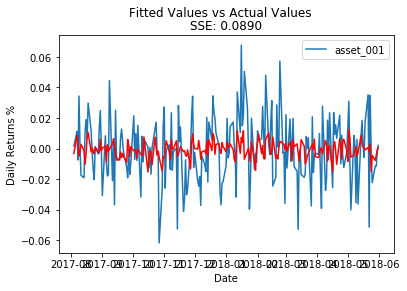

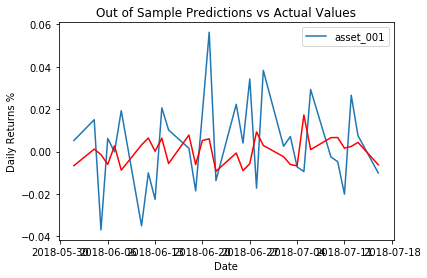

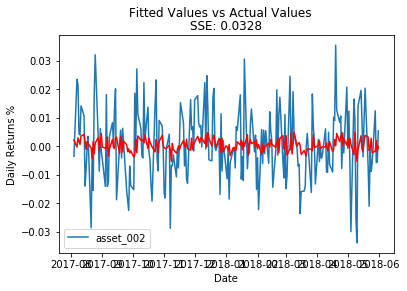

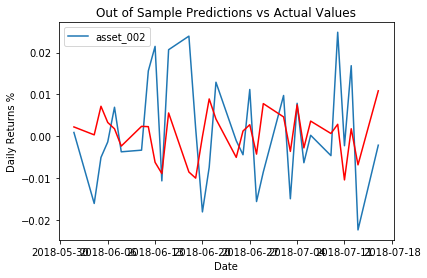

The mean square error for the hold out set predictions is 10.4346407009


In [26]:
# Initialize the training and testing start, end dates. 

train_start = pd.to_datetime('2017-08-04')
train_end = pd.to_datetime('2018-05-31')
test_start = pd.to_datetime('2018-06-01')
test_end = pd.to_datetime('2018-07-16')

# Store sum of squares error and predictions from calling the model
sse1, preds1 = ARMAX(train_start, train_end, test_start, test_end, 2, True, True)
print('The mean square error for the hold out set predictions is '+ str(sse1.mean()))

In [27]:
# Use all data available to predict July 17, 2017
train_start = pd.to_datetime('2017-08-04')
train_end = pd.to_datetime('2018-07-16')
test_start = pd.to_datetime('2018-07-17')
test_end = pd.to_datetime('2018-07-17')

sse2, preds2 = ARMAX(train_start, train_end, test_start, test_end, 200, False, False)

In [23]:
pd.DataFrame(preds2).to_csv('preds_ARMAX.csv')

The second appoach is to use ridge regression as a regularization method to linear regression. The function works similarily to the ARMAX function but implements ridge regression with grid search cross validation instead of the time series ARMAX model. I used values from 0 to 4 by 0.05 for tuning the hyperparameter alpha and fit a second model using the best alpha found from GridSearchCV, storing the predictions and sum of square errors. 

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


def Ridge_Reg(train_start_date, train_end_date, test_start_date, test_end_date, num_of_assets,
          in_sample_plots = False, out_of_sample_plots = False):

    sse = []
    preds_dict = {}
    p = 0
    params = {'alpha':np.arange(0, 4, 0.05)}
    
    for asset in X_with_Lags_dict:
        if p == num_of_assets:
            break
        y = returns[asset].loc[train_start_date:train_end_date]
        X = X_with_Lags_dict[asset].loc[train_start_date:train_end_date, X_with_Lags_dict[asset].columns[0:20]]

        ridge = Ridge()
        grid = GridSearchCV(ridge, params, cv = 3)
        grid.fit(X, y)
        
        ridge2 = Ridge(alpha = grid.best_params_['alpha'])
        ridge2.fit(X, y)
        
        fitted_vals = ridge2.predict(X_with_Lags_dict[asset].loc[train_start_date:train_end_date, 
                                                                 X_with_Lags_dict[asset].columns[0:20]])
        fitted_vals = pd.DataFrame(fitted_vals)
        fitted_vals.index = pd.date_range(start=train_start_date, end=train_end_date, freq = 'B')
        #print(fitted_vals)
        if in_sample_plots == True:
            plt.plot(y)
            plt.plot(fitted_vals, color='red')
            plt.title('SSE: %.4f'% sum((fitted_vals.iloc[:,0]-y)**2))
            plt.legend()
            plt.suptitle('Fitted Values vs Actual Values')
            plt.xlabel('Date')
            plt.ylabel('Daily Returns %')
            plt.show()

        preds = ridge2.predict(X_with_Lags_dict[asset].loc[test_start_date:test_end_date, X_with_Lags_dict[asset].columns[0:20]])
        preds_dict[asset] = preds
        sse = np.append(sse, (np.sum((returns[asset].loc[test_start_date:test_end_date] - preds)**2) * 1000))
        
        if out_of_sample_plots == True:
            preds = pd.DataFrame(preds)
            preds.index = pd.date_range(start=test_start_date, end=test_end_date, freq = 'B')
            plt.plot(returns[asset].loc[test_start_date:test_end_date])
            plt.plot(preds, color = 'red')
            plt.title('Out of Sample Predictions vs Actual Values')
            plt.xlabel('Date')
            plt.ylabel('Daily Returns %')
            plt.show()
        p = p + 1
    return(sse, preds_dict)

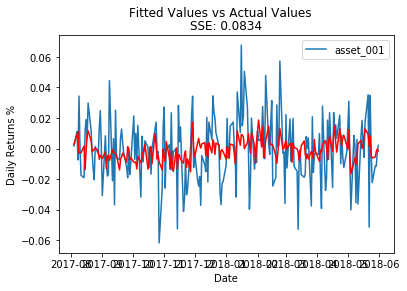

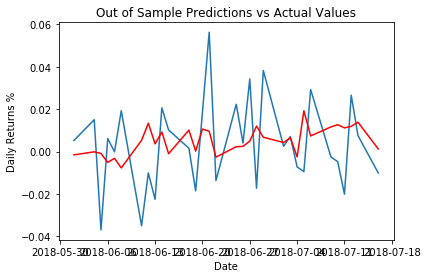

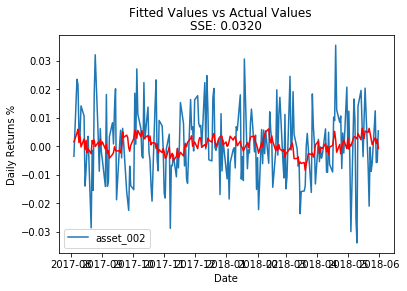

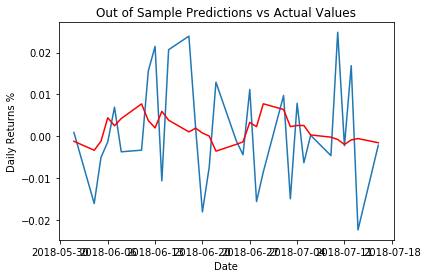

The mean square error for the hold out set predictions is 9.94919791105


In [29]:
# Initialize the training and testing start, end dates. 
train_start = pd.to_datetime('2017-08-04')
train_end = pd.to_datetime('2018-05-31')
test_start = pd.to_datetime('2018-06-01')
test_end = pd.to_datetime('2018-07-16')

sse3, preds3 = Ridge_Reg(train_start, train_end, test_start, test_end, 2, True, True)
print('The mean square error for the hold out set predictions is '+ str(sse3.mean()))

In [30]:
train_start = pd.to_datetime('2017-08-04')
train_end = pd.to_datetime('2018-07-16')
test_start = pd.to_datetime('2018-07-17')
test_end = pd.to_datetime('2018-07-17')

sse4, preds4 = Ridge_Reg(train_start, train_end, test_start, test_end, 200, False, False)

In [550]:
pd.DataFrame(preds4).to_csv('preds_Ridge.csv')